In [165]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


In [176]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [177]:
PATH_MARTI="../Dati/Run_chall_ChargeHistos_4_12_2024_10M.dat"
PATH_SAM="../Dati/12_APR/Run_chall_ChargeHistos_4_12_2024_10M.dat"
edge_N, bin_N = load_histo(PATH_SAM)

channel = 15

if(channel == 12 or channel == 13 or channel == 1):
    exit()

channel_idx = [0, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1, -1, 11, 12]

    
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

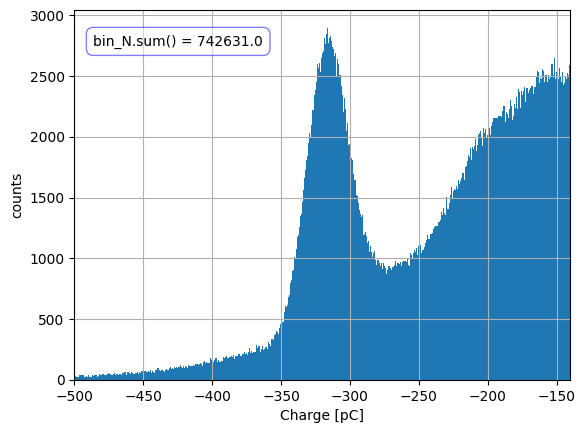

In [215]:
lim_list = [[-600, -165],  #ch0
            [-1, -1],      #ch1
            [-600, -175],  #ch2
            [-600, -145],  #ch3
            [-500, -165],  #ch4
            [-600, -175],  #ch5
            [-600, -155],  #ch6
            [-500, -180],  #ch7
            [-600, -170],  #ch8
            [-500, -160],  #ch9
            [-500, -190],  #ch10
            [-600, -165],  #ch11
            [-1, -1],      #ch12
            [-1, -1],      #ch13
            [-600, -140],  #ch14
            [-500, -140]   #ch15
            ]


lim_N = lim_list[channel]
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))
plt.bar(centers_N, bin_N)#, width = 1)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [182]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

In [183]:
#DEFINIAMO IL MODELLO
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide


params = exp1.guess(bin_N, x=centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))


model = exp1 + gauss1 + sigmoid1 + sigmoid2  

In [184]:
#CARICHIAMO I VALORI DI PARTENZA SU RUMORE
import pickle
with open("../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    noise_params = pickle.load(f)

if (channel <14):
    noise_params = noise_params[channel]
elif(channel==14):
    noise_params = noise_params[12]
elif(channel==15):
    noise_params = noise_params[13]

noise_params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude  1.316e+04     -inf      inf      190     True     None     None
e1_decay        -83.88     -inf      inf   0.6513     True     None     None
ratio            23.95     -inf      inf   0.4402    False e1_amplitude / s1_amplitude     None
s1_amplitude     549.3        0      inf    9.749     True     None     None
s1_center       -400.3     -inf      inf   0.9277     True     None     None
s1_sigma         28.79        0      inf   0.6732     True     None     None


In [185]:
#IMPOSTIAMO I PARAMETRI
params["s1_amplitude"].min = 0
params["s2_amplitude"].min = 0
params["g1_amplitude"].min = 0
params["e1_amplitude"].min = 0

params["s1_amplitude"].value = noise_params["s1_amplitude"].value
params["s1_center"].value = noise_params["s1_center"].value
params["s1_sigma"].value = noise_params["s1_sigma"].value
params["e1_decay"].value = noise_params["e1_decay"].value
params.add("ratio", value = noise_params["ratio"].value)
params["e1_amplitude"].set(vary=True, expr = "ratio * s1_amplitude")



# Fit the model to the data
if channel ==0:
    params["g1_amplitude"].set(value = 70348, min=0 )   
    params["g1_center"].set(value = -309, min = -350 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

    params["e1_amplitude"].set(min=0)
    params["e1_decay"].set(value=-61)

    params["s1_amplitude"].set(value= 1534, min = 0)
    params["s1_center"].set(value=-270)
    params["s1_sigma"].set( value= 60)

    params["ratio"].set( value=4.89)

if channel ==2:

    params["g1_amplitude"].set(value = 425000 , min=0)   
    params["g1_center"].set(value = -325, min = -350 , max = -300)        
    params["g1_sigma"].set(value = 15)

    params["s2_amplitude"].set(value = 5000, min=0)
    params["s2_center"].set(value = -230, min=-350,max=-150 )
    params["s2_sigma"].set(value = 5)

    params["e1_amplitude"].value = 54057.2496

    params["s1_amplitude"].set(min = 0)

if channel ==3:

    params["g1_amplitude"].set(value = 425000, min=0 )   
    params["g1_center"].set(value = -325, min = -350 , max = -300)        
    params["g1_sigma"].set(value = 15)

    params["s2_amplitude"].set(value = 675, min=0)
    params["s2_center"].set(value = -230, min=-350,max=-150 )
    params["s2_sigma"].set(value = 5)

    params["e1_amplitude"].set( min=0)
    params["e1_decay"].set(value=-93)
    
    params["s1_amplitude"].set(value=927, min = 0)

    params["ratio"].set(value=7.71)

if channel == 4:
    
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -290, min = -340 , max = -260)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0, max=1000)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 2)
   
if channel == 5:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -300, min = -330 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=50, max=1000)
    params["s2_center"].set(value = -180, min=-250,max=-150 )
    params["s2_sigma"].set(value = 9, min=0 )

    params["s1_amplitude"].set(value=1000)

if channel ==6:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -280, min = -320 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0, max=1000)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

    params["s1_amplitude"].set(value=1000)

if channel ==7:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -340, min = -380 , max = -300)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

 
if channel == 8:
    params["g1_center"].set(value = -311)
    params["g1_sigma"].set(value = 14)
    params["e1_amplitude"].set(value = 6225)
    params["e1_decay"].set(value = -57)
    params["s1_amplitude"].set(value = 1380)
    params["s1_center"].set(value = -304)
    params["s1_sigma"].set(value = 14)
    params["s2_amplitude"].set(value = 885)
    params["s2_center"].set(value = -220)
    params["s2_sigma"].set(value = 11)


if channel == 9:
    params["g1_center"].value = -290
    params["g1_center"].min = -300
    params["g1_sigma"].value = 22
    params["g1_amplitude"].value = 60000

    params["e1_amplitude"].value = 12000
    params["e1_decay"].value = -60

    params["s2_center"].value = -250
    params["s2_center"].min = -340

    params["s2_amplitude"].value = 300
    params["s2_amplitude"].max = 930
    params["s2_amplitude"].min = 180
    params["s2_sigma"].value = 6
    params["s2_center"].value = -250


    params["s1_center"].value = -450 

    params["s1_amplitude"].value = 2000  
    params["s1_amplitude"].max = 10050    
  



if channel == 10:
    params["g1_center"].value = -400
    params["g1_center"].max = -380
    params["s2_amplitude"].max= 1000
    params["s2_center"].min = -350
    params["s2_center"].max = -150
         




    

    

params.update(params)
params.pretty_print()


Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude  1.316e+04        0      inf     None    False ratio * s1_amplitude     None
e1_decay        -83.88     -inf      inf     None     True     None     None
g1_amplitude         0        0      inf     None     True     None     None
g1_center         -320     -inf      inf     None     True     None     None
g1_fwhm          58.87     -inf      inf     None    False 2.3548200*g1_sigma     None
g1_height            0     -inf      inf     None    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma            25        0      inf     None     True     None     None
ratio            23.95     -inf      inf     None     True     None     None
s1_amplitude     549.3        0      inf     None     True     None     None
s1_center       -400.3     -inf      inf     None     True     None     None
s1_sigma         28.79        0      inf     None     True     None     None
s2_amplitude    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


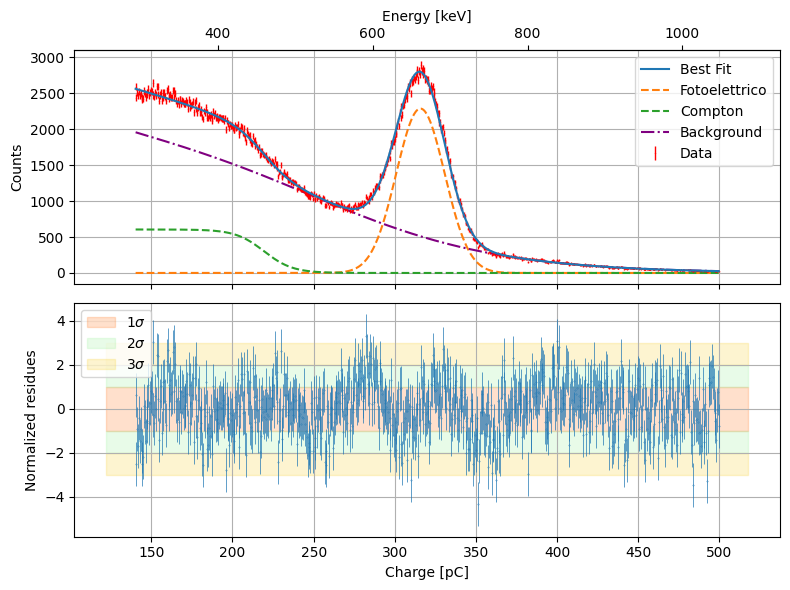

In [286]:
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)

def pCtoKev(x):
    return -x / result.params["g1_center"].value * 661.7

def KevtopC(x):
    return -x * result.params["g1_center"].value / 661.7



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex = True)


#ax1.bar(centers_N, bin_N, alpha = 0.5, width = 0.7)
#ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(-centers_N[::-1], result.best_fit[::-1], label='Best Fit', zorder = 10)
ax1.plot(-centers_N[::-1], comps['g1_'][::-1], label='Fotoelettrico', ls = "--")
ax1.plot(-centers_N[::-1], comps['s2_'][::-1], label='Compton', ls = "--")

ax1.plot(-centers_N[::-1], comps['e1_'][::-1] + comps['s1_'][::-1], label='Background', ls = "-.",
         color = "purple")
         #color = "#17BEBB")
#ax1.plot(centers_N, comps['e1_'], label='Background Exp', ls = "-.")
#ax1.plot(centers_N, comps['s1_'], label='Background FD', ls = "-.")

ax1.errorbar(-centers_N[::-1], bin_N[::-1], err_N[::-1], color = "red", fmt='|', linewidth = 1, 
             markersize = 0.5, label = "Data")
ax1.grid()
ax1.legend()


residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(-centers_N[::-1], norm_resCs[::-1], 1, ls = "", marker = ".", linewidth = 0.5, markersize = 0.5)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "#FF6700", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "#F7CB15", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "#F7CB15", alpha = 0.2)

ax2.legend()

secax = ax1.secondary_xaxis('top', functions=(pCtoKev, KevtopC))
secax.set_xlabel('Energy [keV]')
'''
ax3 = ax2.twinx()
ax3.set_xticks(pCtoKev(np.array(ax1.get_xticks())))
ax3.set_xlabel("Energy [keV]")
ax3.set_xticklabels(np.round(pCtoKev( np.array(ax1.get_xticks())) ))
ax3.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax3.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax3.spines['bottom'].set_position(('outward', 36))

ax3.set_xlim(np.array(ax1.get_xlim()) * -result.params["g1_center"].value / 661.7)


ax3.plot()
'''
fig.tight_layout()

plt.show()

In [263]:
ax1.get_xticks()

array([100., 150., 200., 250., 300., 350., 400., 450., 500., 550.])

In [254]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 603
    # data points      = 692
    # variables        = 11
    chi-square         = 954.509769
    reduced chi-square = 1.40162962
    Akaike info crit   = 244.555450
    Bayesian info crit = 294.490895
    R-squared          = 0.99999844
[[Variables]]
    e1_amplitude:  1680.84763 +/- 1902.13911 (113.17%) == 'ratio * s1_amplitude'
    e1_decay:     -68.5000120 +/- 139.282954 (203.33%) (init = -83.88444)
    s1_amplitude:  1969.41560 +/- 1012.38003 (51.41%) (init = 549.292)
    s1_center:    -254.436988 +/- 26.8106441 (10.54%) (init = -400.3329)
    s1_sigma:      56.1191425 +/- 7.35097842 (13.10%) (init = 28.79496)
    g1_amplitude:  85417.6813 +/- 642.322961 (0.75%) (init = 0)
    g1_center:    -315.815136 +/- 0.06675255 (0.02%) (init

## Sistematiche

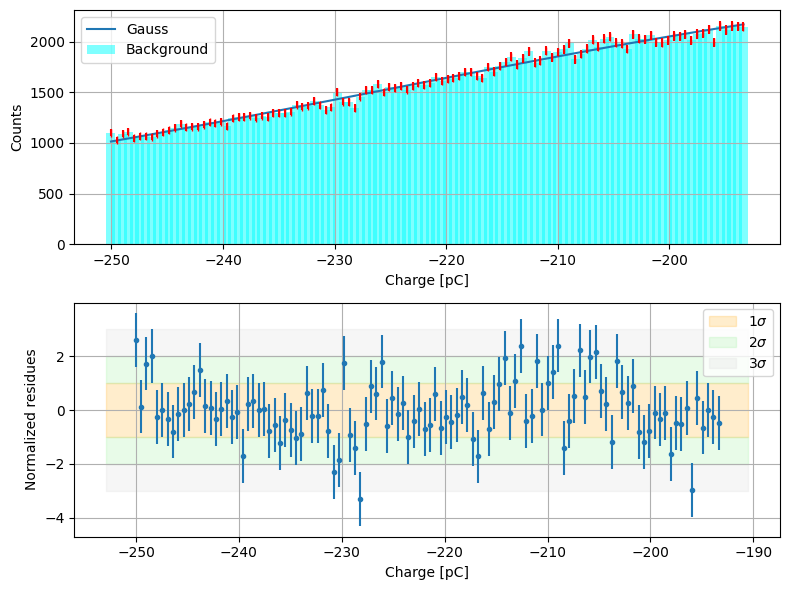

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 110
    # variables        = 3
    chi-square         = 129.182609
    reduced chi-square = 1.20731410
    Akaike info crit   = 23.6821274
    Bayesian info crit = 31.7835685
    R-squared          = 0.99999028
[[Variables]]
    g3_amplitude:  453200.603 +/- 46208.2056 (10.20%) (init = 46631.52)
    g3_center:    -153.578030 +/- 7.45636601 (4.86%) (init = -207.14)
    g3_sigma:      71.2315449 +/- 3.96486670 (5.57%) (init = 13.78)
    g3_fwhm:       167.737464 +/- 9.33654741 (5.57%) == '2.3548200*g3_sigma'
    g3_height:     2538.21385 +/- 119.256260 (4.70%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_center) = +0.9996
    C(g3_amplitude, g3_sigma)  = +0.9944
    C(g3_center, g3_sigma)     = +0.9939


In [188]:
sist_lim_list = [[510, 605],  #ch0
                [-1, -1],  #ch1
                [460, 565],  #ch2
                [490, 585],  #ch3
                [350, 430],  #ch4
                [550, 630],  #ch5
                [550, 660],  #ch6
                [250, 350],  #ch7
                [500, 600],  #ch8
                [340, 470],  #ch9
                [180, 270],  #ch10
                [540, 630],  #ch11
                [-1, -1],  #ch12
                [-1, -1],  #ch13
                [460, 585],  #ch14
                [480, 590]   #ch15
                ]


sist_lims = sist_lim_list[channel]
sist_bin = bin_N[sist_lims[0]:sist_lims[1]]
sist_cntr = centers_N[sist_lims[0]:sist_lims[1]]
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

In [189]:
print(f'La sistematica è {result.params["g1_center"].value - result2.params["g3_center"].value}')

La sistematica è -162.23710623541763
